In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras import objectives
from keras.optimizers import RMSprop
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

from sklearn.ensemble import RandomForestRegressor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/audio-binary-classification/train_labels.csv
/kaggle/input/audio-binary-classification/sample_submission.csv
/kaggle/input/audio-binary-classification/train_data.npy
/kaggle/input/audio-binary-classification/test_data.npy


In [2]:
x_train = np.load('/kaggle/input/audio-binary-classification/train_data.npy');
x_test = np.load('/kaggle/input/audio-binary-classification/test_data.npy');


print("inputs loaded")

inputs loaded


44100
(3999, 44100)
(3999, 44100)


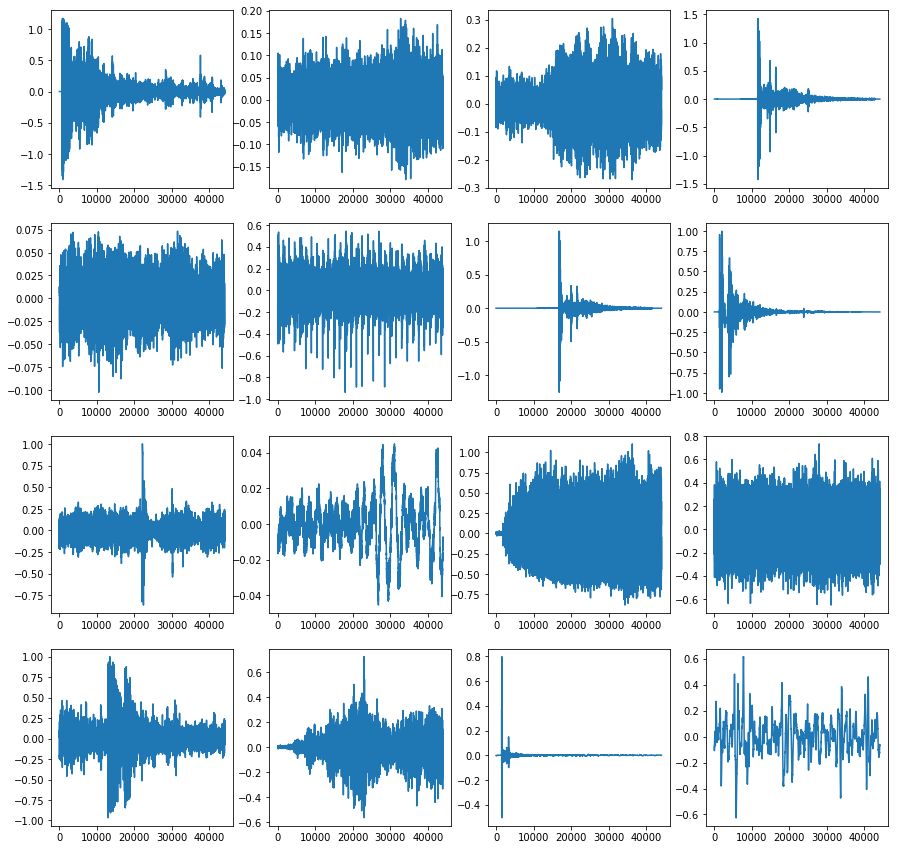

In [3]:
#Scale and Reshape
x_train = x_train.astype('float32');
x_test = x_test.astype('float32');

#Normalize Data
#x_train /= np.amax(x_train);
#x_test /= np.amax(x_test);

original_dim = x_train.shape[1];
print(original_dim);

print(x_train.shape);

x_train = x_train.reshape(-1,original_dim);
x_test = x_test.reshape(-1,original_dim);

input_shape = x_train.shape;
print(input_shape);

#Look at it
fig1,axs1 = plt.subplots(4,4,figsize=(15,15));
plt.rcParams.update({'font.size':1})

for i in range(4):
    for j in range(4):
        axs1[i,j].plot(x_train[i*30 + j,:])

In [4]:
#Look at CSV and store as array
train_labels = pd.read_csv("/kaggle/input/audio-binary-classification/train_labels.csv");
train_labels = train_labels.values;
train_labels = train_labels[:,1];
print(train_labels[:10]);
print(train_labels.shape)

[0 0 0 1 0 0 1 0 1 0]
(3999,)


In [5]:
latent_dim = 30;
intermediate_dim = 2;
batch_size = 25;
original_dim = 44100;

In [6]:
x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0.)
    return z_mean + K.exp(z_log_sigma) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_sigma])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [7]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# end-to-end autoencoder
vae = Model(x, x_decoded_mean)

# encoder, from inputs to latent space
encoder = Model(x, z_mean)

# generator, from latent space to reconstructed inputs
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [8]:
def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

rms = RMSprop(lr=0.0001, rho=0.9)
vae.compile(optimizer=rms, loss=vae_loss)

In [9]:
#for posterity's sake
train_x = x_train;

In [10]:
#I dont know why it doesnt work with the full. needs to be multiple of 25? Ewwwww
x_train = x_train[:3975];

In [11]:
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=250,
        batch_size=25)

Epoch 1/250
3975/3975 [==============================] - 8s 2ms/step - loss: 0.6846
Epoch 2/250
3975/3975 [==============================] - 7s 2ms/step - loss: 0.6656
Epoch 3/250
3975/3975 [==============================] - 7s 2ms/step - loss: 0.6456
Epoch 4/250
3975/3975 [==============================] - 7s 2ms/step - loss: 0.6256
Epoch 5/250
3975/3975 [==============================] - 7s 2ms/step - loss: 0.6021
Epoch 6/250
3975/3975 [==============================] - 8s 2ms/step - loss: 0.5755
Epoch 7/250
3975/3975 [==============================] - 8s 2ms/step - loss: 0.5470
Epoch 8/250
3975/3975 [==============================] - 7s 2ms/step - loss: 0.5199
Epoch 9/250
3975/3975 [==============================] - 7s 2ms/step - loss: 0.4906
Epoch 10/250
3975/3975 [==============================] - 7s 2ms/step - loss: 0.4577
Epoch 11/250
3975/3975 [==============================] - 7s 2ms/step - loss: 0.4260
Epoch 12/250
3975/3975 [==============================] - 7s 2ms/step - lo

[[ 0.01802181 -0.01137397  0.02072202 ...  0.00747374 -0.02029065
  -0.030182  ]
 [ 0.01802181 -0.01137397  0.02072202 ...  0.00747374 -0.02029065
  -0.030182  ]
 [ 0.01802181 -0.01137397  0.02072202 ...  0.00747374 -0.02029065
  -0.030182  ]
 ...
 [ 0.01802181 -0.01137397  0.02072202 ...  0.00747374 -0.02029065
  -0.030182  ]
 [ 0.01802181 -0.01137397  0.02072202 ...  0.00747374 -0.02029065
  -0.030182  ]
 [ 0.01802181 -0.01137397  0.02072202 ...  0.00747374 -0.02029065
  -0.030182  ]]


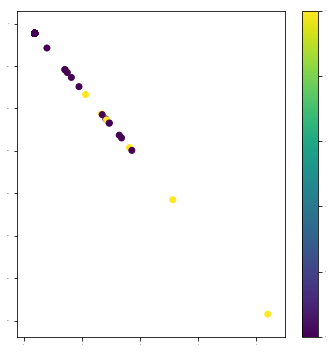

In [12]:
x_train_encoded = encoder.predict(x_train, batch_size=25)
print(x_train_encoded)
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], c=train_labels[:3975])
plt.colorbar()
plt.show()

In [13]:
'''
n = 10
digit_size = 44100;
figure = np.zeros((digit_size,n,n))

gx = np.linspace(-10,10,n);
gy = np.linspace(-10,10,n)

fig,axs = plt.subplots(n,n,figsize=(15,15));
plt.rcParams.update({'font.size':1})

for i, yi in enumerate(gx):
    for j, xi in enumerate(gy):
        z_sample = np.array([[xi,yi]]) * 1.0;
        x_decoded = generator.predict(z_sample)
        digit  = x_decoded[0].reshape(44100);
        figure[:,i,j] = digit
        axs[i,j].plot(digit);
        
print(figure.shape);
'''

"\nn = 10\ndigit_size = 44100;\nfigure = np.zeros((digit_size,n,n))\n\ngx = np.linspace(-10,10,n);\ngy = np.linspace(-10,10,n)\n\nfig,axs = plt.subplots(n,n,figsize=(15,15));\nplt.rcParams.update({'font.size':1})\n\nfor i, yi in enumerate(gx):\n    for j, xi in enumerate(gy):\n        z_sample = np.array([[xi,yi]]) * 1.0;\n        x_decoded = generator.predict(z_sample)\n        digit  = x_decoded[0].reshape(44100);\n        figure[:,i,j] = digit\n        axs[i,j].plot(digit);\n        \nprint(figure.shape);\n"

In [14]:
x_train = train_x;
x_inp = encoder.predict(x_train);
print(x_inp);
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42);
rf.fit(x_inp,train_labels);

[[ 0.01802181 -0.01137397  0.02072202 ...  0.00747374 -0.02029065
  -0.030182  ]
 [ 0.01802181 -0.01137397  0.02072202 ...  0.00747374 -0.02029065
  -0.030182  ]
 [ 0.01802181 -0.01137397  0.02072202 ...  0.00747374 -0.02029065
  -0.030182  ]
 ...
 [ 0.01802181 -0.01137397  0.02072202 ...  0.00747374 -0.02029065
  -0.030182  ]
 [ 0.01802181 -0.01137397  0.02072202 ...  0.00747374 -0.02029065
  -0.030182  ]
 [ 0.01802181 -0.01137397  0.02072202 ...  0.00747374 -0.02029065
  -0.030182  ]]


In [15]:
y_inp = encoder.predict(x_test);
Y_pred = rf.predict(y_inp);
print(Y_pred)
df_pred = pd.DataFrame(Y_pred);
df_pred.index.name = "Id"
df_pred = pd.DataFrame.rename(df_pred,columns={0:"Label"})
print(df_pred);
df_pred.to_csv("output.csv")

[0.12038775 0.12038775 0.12038775 ... 0.12038775 0.12038775 0.61409354]
         Label
Id            
0     0.120388
1     0.120388
2     0.120388
3     0.120388
4     0.120388
...        ...
3992  0.120388
3993  0.120388
3994  0.120388
3995  0.120388
3996  0.614094

[3997 rows x 1 columns]
